## Aim
* Given a stereo pair directory and a smaller processing extent,this notebook will:
    * Find the more nadir left image
    * Project the processing extent to it's corresponding extent in pixel coordinate system of the left image
    * Prepare ASP jobs with different correlator flavors for that small processing extent
* **Todo** Cleanup and add other job types

In [63]:
%cd /panfs/ccds02/nobackup/people/sbhusha1/ostfl/maxar/pcd
asp_exec = "/panfs/ccds02/nobackup/people/sbhusha1/sw/StereoPipeline-3.5.0-alpha-2025-04-17-x86_64-Linux/bin/"

/panfs/ccds02/nobackup/people/sbhusha1/ostfl/maxar/pcd


In [64]:
import os,glob,sys
import subprocess
from dgtools import dglib
import rpcm
import geopandas as gpd
import contextily
import xyzservices
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

In [65]:
terrain_map = xyzservices.providers.Esri.WorldImagery() #Used to render basemap

## Sample directory

In [66]:
stereo_directory = 'WV03WV03_20210920_104001006E942500_104001006D788E00/'

In [67]:

pair_metadata = dglib.dir_pair_dict(stereo_directory)

id1 = pair_metadata['id1_dict']['id']
gsd1 = pair_metadata['id1_dict']['gsd']
id2 = pair_metadata['id2_dict']['id']
gsd2 = pair_metadata['id2_dict']['gsd']

if gsd1<gsd2:
    #ID1 image is finer resolution
    left_img = sorted(glob.glob(os.path.join(stereo_directory,f"{id1}*r100.tif")))[0]
    right_img = sorted(glob.glob(os.path.join(stereo_directory,f"{id2}*r100.tif")))[0]
else:
    #ID2 image is finer resolution
    left_img = sorted(glob.glob(os.path.join(stereo_directory,f"{id2}*r100.tif")))[0]
    right_img = sorted(glob.glob(os.path.join(stereo_directory,f"{id1}*r100.tif")))[0]

left_xml = os.path.splitext(left_img)[0]+".xml"
right_xml = os.path.splitext(right_img)[0]+".xml"
left_footprint = dglib.xml2gdf(left_xml)
left_rpc = rpcm.rpc_from_geotiff(left_img)

In [68]:
processing_extent = gpd.read_file(glob.glob(os.path.join(stereo_directory,'processing_extent.geojson'))[0])

In [69]:
proj_crs = left_footprint.estimate_utm_crs()
epsg_code = proj_crs.to_epsg()

Total scene area: 235.38 km2
Processing extent area: 61.11 km2


/explore/nobackup/people/sbhusha1/.nccstmp/ipykernel_124567/3341910874.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/explore/nobackup/people/sbhusha1/.nccstmp/ipykernel_124567/3341910874.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


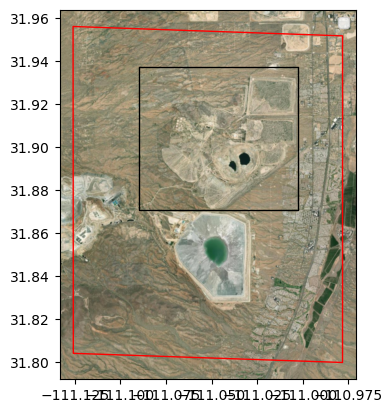

In [70]:
f,ax = plt.subplots()
left_footprint.plot(ax=ax,edgecolor='Red',facecolor='None',label='Full image extent')
processing_extent.plot(ax=ax,edgecolor='k',facecolor='None',label='Processing extent')
contextily.add_basemap(source=contextily.providers.Esri.WorldImagery,ax=ax,attribution=False,crs='EPSG:4326')
print(f"Total scene area: {left_footprint.to_crs(proj_crs).area.values[0]*1e-6 :.2f} km2")
print(f"Processing extent area: {processing_extent.to_crs(proj_crs).area.values[0]*1e-6 :.2f} km2")
ax.legend()

In [71]:
## this will be slightly approximate as we are not using the elevation values for transformation, but works for our purposes
poly_points = list(processing_extent.geometry.values[0].exterior.coords)
left_img_box = []
for point in poly_points:
    left_img_box.append(left_rpc.projection(point[0],point[1],0))

In [72]:
xmin,ymin,xmax,ymax = Polygon(left_img_box).bounds
xsize = xmax-xmin
ysize = ymax-ymin
left_img_crop_win = f'{xmin} {ymin} {xsize} {ysize}'

In [73]:
left_img_crop_win

'9651.175219588487 4890.977839392595 25234.005560079666 23810.65112045334'

#### Prepare job

In [74]:
parent_dir = "/panfs/ccds02/nobackup/people/sbhusha1/ostfl/maxar/pcd/"

In [75]:
job_fn = f"opencv_block_job_arizona_mine.sh"
output_directory = os.path.join(stereo_directory,'cpu/opencv_block/opencv_block_processing')


opencv_alg1 = "opencv_bm -block_size 21 -texture_thres 10"
opencv_alg2 = " -prefilter_cap 31 -uniqueness_ratio 15 -speckle_size 100"
opencv_alg3 = " -speckle_range 32 -disp12_diff 1"
opencv_alg = opencv_alg1 + opencv_alg2 + opencv_alg3


opencv_sgm_opt = f' -t rpc --alignment-method local_epipolar --stereo-algorithm "{opencv_alg}"  --left-image-crop-win {left_img_crop_win}'

opencv_args = f' {left_img} {left_xml} {right_img} {right_xml} {output_directory}'

parallel_stereo_call = "/panfs/ccds02/nobackup/people/sbhusha1/sw/StereoPipeline-3.5.0-alpha-2025-04-17-x86_64-Linux/bin/parallel_stereo"
parallel_stereo_cmd = f'time {parallel_stereo_call} {opencv_sgm_opt} {opencv_args}'

output_pointcloud = f"{output_directory}*-PC.tif"

p2dem_call = "/panfs/ccds02/nobackup/people/sbhusha1/sw/StereoPipeline-3.5.0-alpha-2025-04-17-x86_64-Linux/bin/point2dem"
p2dem_opts = f"--tr 4.0 --nodata-value -9999.0 --t_srs EPSG:{epsg_code} --errorimage"
p2dem_cmd = f'time {p2dem_call} {p2dem_opts} {output_pointcloud}'

with open(job_fn,'w') as f:
    slurm_keyword = f'#! /bin/bash\n#SBATCH --job-name={os.path.basename(job_fn)} -t 30:00:00 -c30 --mem=120G'
    directory_change = f'cd {parent_dir}'
    out_str = slurm_keyword+"\n"+directory_change+"\n"+parallel_stereo_cmd+"\n"+p2dem_cmd
    f.write(out_str)

In [76]:
pwd

'/panfs/ccds02/nobackup/people/sbhusha1/ostfl/maxar/pcd'